## Inverse FFD

"Fitting mesh deformation to Free-Form Deformation (namely, inverse FFD)"  
Sorry, it contains some Japanese content for the clearance at this moment.  
After clearing the ambiguity, I rephrase all Japanese to English if needed.  

### Requirements

- [numpy], [scipy]  
- [matplotlib]  
- **[libigl]**: right now, I only use this to load obj file.  
  However, I also need to implement mesh extraction so I keep this.  

[numpy]:https://numpy.org/
[scipy]:https://www.scipy.org/
[matplotlib]:https://matplotlib.org/
[libigl]:https://libigl.github.io/libigl-python-bindings/

## TODOs

These should be done with few work.

- Filtering out non-assigned grid points from sparse matrix $\tilde{\mathrm{B}}$ and vector $\mathrm{P}$  
- Adding regularization term in Least-Squares formulation  

These will takes several efforts, so I just note them.  

- Filtering (or selecting) the submesh from the full mesh, not from the separated mesh  
- Keeping consistency between forward and inverse FFD  


### Formulation

#### 入力データ: 頂点群 $(\mathbf{x}, \mathbf{u})$

UV座標の付与されている，$k$個の頂点を持つ頂点 $(\mathbf{x}, \mathbf{u})_k$  

- XY空間での座標 $\mathbf{x}_k = (x_k,y_k) \in \mathfrak{X} $ と
- UV空間での座標 $\mathbf{u}_k = (u_k,v_k) \in \mathfrak{U} $ を持っている．

#### 目標出力: 制御点群 $\mathrm{P}$

制御点 $B_{ij} \in \mathfrak{U}$ に対応する点 $P_{ij} \in \mathfrak{X}$  


In [1]:
## load mesh data ...
import numpy as np
import igl

## [TEMPORARY] load already separated mesh
x, u, _, tri, _, _ = igl.read_obj('data/4_L.obj')

x = x[:,:2] ## reduce vertex dimension: 3D -> 2D

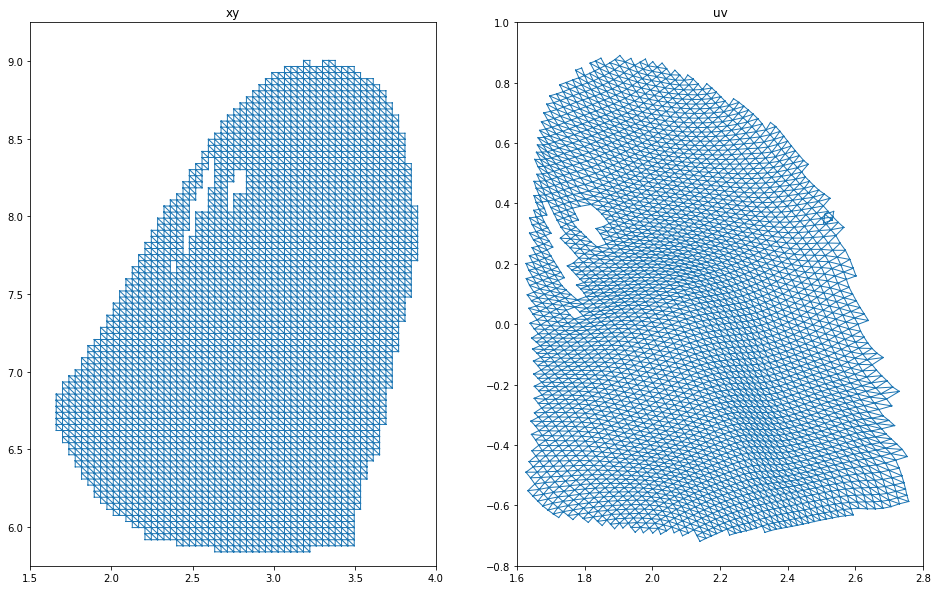

In [2]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))

############################################################
## XY-space
############################################################
ax1.set_title('xy')

ax1.set_xlim([1.5,4.0]) ## 2.5
ax1.set_ylim([5.75,9.25]) ## 4.0
ax1.triplot(x[:,0], x[:,1], tri, linewidth=1.0)

############################################################
## UV-space
############################################################
ax2.set_title('uv')

ax2.set_xlim([ 1.6,2.8]) ## 1.2
ax2.set_ylim([-0.8,1.0]) ## 1.8
ax2.triplot(u[:,0], u[:,1], tri, linewidth=1.0)

plt.show()

### Procedure

#### 1. Initialization: グリッド点 $\mathrm{B}$ (自動生成)

1. Bounding Box を計算する (単純)  
2. Subdivision few times **$\leftarrow$ まず適当に回数を決める**  
3. Bounding box の成す頂点が $B_{ij}$ となる  


In [3]:
## compute bounding box
u_min, u_max = np.min(u[:,0]), np.max(u[:,0])
v_min, v_max = np.min(u[:,1]), np.max(u[:,1])

print(u_min, v_min, u_max, v_max)

1.62583 -0.7189 2.75779 0.88979


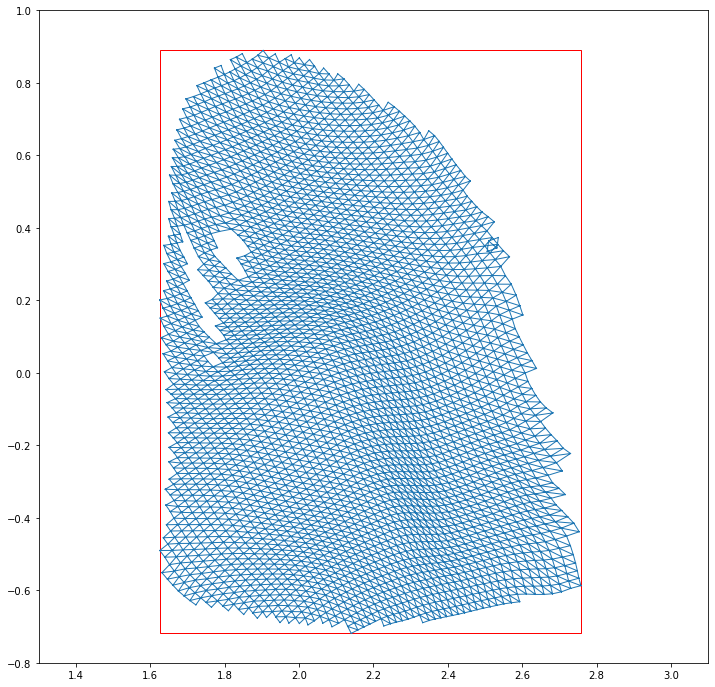

In [4]:
## visualize bounding box
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xlim([1.3,3.1])
ax.set_ylim([-0.8,1.0])
ax.triplot(u[:,0], u[:,1], tri, linewidth=1.0)

ax.add_patch(Rectangle((u_min, v_min), u_max-u_min, v_max-v_min, edgecolor='red', fill=False))

plt.show()

In [5]:
## subdivide bounding box
## [TEMPORARY] just use fixed number of grid points
B_i = np.linspace(u_min, u_max, num=8)
B_j = np.linspace(v_min, v_max, num=10)

B_ix, B_jy = np.meshgrid(B_i, B_j)

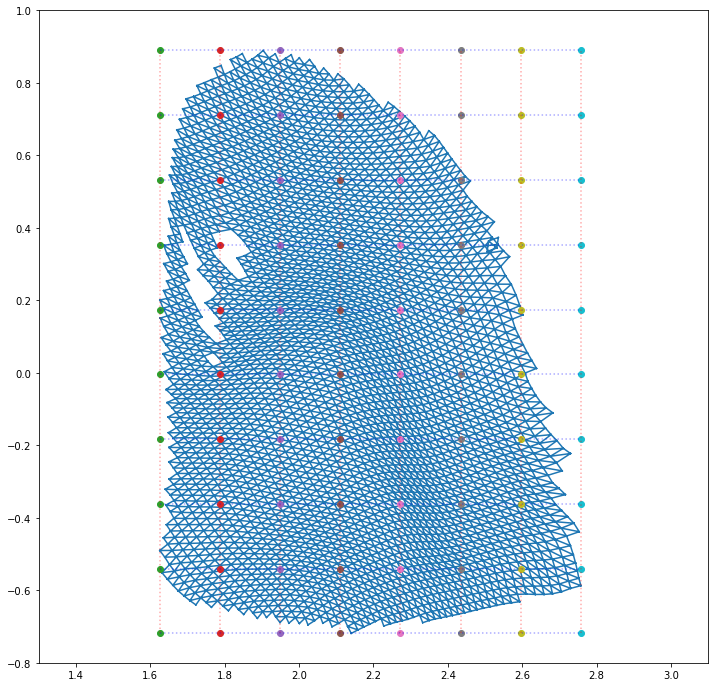

In [6]:
## visualize bounding box
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xlim([1.3,3.1])
ax.set_ylim([-0.8,1.0])

ax.triplot(u[:,0], u[:,1], tri)

## grid points
ax.plot(B_ix, B_jy, 'o')

## draw lines between grid points
for Bx in B_i:
    plt.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    plt.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

plt.show()

In [7]:
## [TODO] filtering out non-assigned grid points



In [8]:
## get the grid points B_{ij}
B_ij = np.dstack((B_ix, B_jy)).reshape(-1,2)

#### 2. Definition of cost function $\mathcal{O}$

$\mathcal{O} = \sum_k{ |\mathbf{x}_k - X(\mathbf{u}_k, \mathrm{P})|^2 } $
where
$X(\mathbf{u}, \mathrm{P}) = \sum_{ij}{ {B}_{ij}(\mathbf{u}) \cdot {P}_{ij} }$  

現在，$ {B}_{ij}(\mathbf{u})$ はその$\mathbf{u}$を囲っている4つの制御点までの補間における単純重みとしている． <mark>(改善の余地あり)</mark>  

![Linear interpolation](LinearInterpolation.svg)


#### 3. Construction of sparse matrix

最後に，疎行列ソルバーを用いて最小二乗法を解く方法について触れておく．  

- $\mathbf{x}$: 定数項として働く, $({k},{2})$, 既知  
- $\mathrm{P}$: 2次元のグリッド交差点数 $({i}\times{j},{2})$, **<mark>未知</mark>**  
- $B_{ij}(\mathbf{u})$: 2次元のグリッド交差点とUV座標からなる疎行列, $({k},{{i}\times{j}})$  

$$ \begin{pmatrix}
    \mathbf{x}_1 \\
    \mathbf{x}_2 \\
    \vdots \\
    \mathbf{x}_k \\
  \end{pmatrix}
- \begin{bmatrix} B_{ij}(\mathbf{u}) \end{bmatrix}
  \begin{pmatrix} 
    P_{11} \\
    P_{12} \\
    \vdots \\
    P_{ij} \\
  \end{pmatrix} $$
  
行列$\mathrm{B}$の成分$B_{ij}(\mathbf{u})$は，グリッド内であるかを判定し，各制御点までの線形補間の値としているため，行列$B_{ij}(\mathbf{u})$には行辺り４つの成分しか存在しない．  
$k$行目に注目してみれば容易に検証可能である:  

$$ \begin{pmatrix} \vdots \\ \mathbf{x}_k \\ \vdots \end{pmatrix}
- \begin{bmatrix}
    {} &\vdots & \vdots & {} & \vdots & \vdots & {} \\
    \cdots & {B}_{i,j}(\mathbf{u}_k) & {B}_{i+1,j}(\mathbf{u}_k ) &
    \cdots & {B}_{i,j+1}(\mathbf{u}_k) & {B}_{i+1,j+1}(\mathbf{u}_k) & \cdots \\
    {} &\vdots & \vdots & {} & \vdots & \vdots & {} \\
  \end{bmatrix}
  \begin{pmatrix} \vdots \\ P_{i,j} \\ P_{i+1,j} \\ \vdots \\ P_{i,j+1} \\ P_{i+1,j+1} \\ \vdots \end{pmatrix}
$$


最後に，通常の最小二乗法のソルバーに落とし込むために，２次元の列部分を１次元化に落とす:  

$$ \begin{pmatrix} \vdots \\ x_k \\ y_k \\ \vdots \end{pmatrix}
- \begin{bmatrix}
    {} &\vdots & \vdots & \vdots & \vdots & {} & \vdots & \vdots & \vdots & \vdots & {} \\
    \cdots & w_i w_j & {\cdot} & w_{i+1} w_j & {\cdot} &
    \cdots & w_i w_{j+1} & {\cdot} & w_{i+1} w_{j+1} & {\cdot} & \cdots \\
    \cdots & {\cdot} & w_i w_j & {\cdot} & w_{i+1} w_j &
    \cdots & {\cdot} & w_i w_{j+1} & {\cdot} & w_{i+1} w_{j+1} & \cdots \\
    {} &\vdots & \vdots & \vdots & \vdots & {} & \vdots & \vdots & \vdots & \vdots & {} \\
  \end{bmatrix}
  \begin{pmatrix}
    \vdots \\ P_{i,j}^x \\ P_{i,j}^y \\ P_{i+1,j}^x \\ P_{i+1,j}^y \\
    \vdots \\ P_{i,j+1}^x \\ P_{i,j+1}^y \\ P_{i+1,j+1}^x \\ P_{i+1,j+1}^y \\ \vdots
  \end{pmatrix}
$$

$$
= \tilde{\mathbf{x}} - \begin{bmatrix} \tilde{B_{ij}}(\mathbf{u}) \end{bmatrix} \tilde{\mathrm{P}}
$$

まとめると，  

- $\tilde{\mathbf{x}}$: 定数項として働く行ベクトル $({k}\times{2},1)$   
- $\tilde{\mathrm{B}}$: 2次元のグリッド交差点とUV座標からなる疎行列, $({k}\times{2},{{i}\times{j}\times{2}})$
- $\tilde{\mathrm{P}}$: 未知数の，2次元のグリッド交差点の座標を表す行ベクトル $({i}\times{j}\times{2},1)$  


In [9]:
## construct sparse matrix
from scipy.sparse import dok_matrix

B_tilde = dok_matrix((x.size, B_ij.size), dtype=np.float32)

def ForEachUV(k, u_k, v_k):
    
    for i in range(len(B_i)-1):
        if (B_i[i] <= u_k and u_k <= B_i[i+1]):
            break
    
    for j in range(len(B_j)-1):
        if (B_j[j] <= v_k and v_k <= B_j[j+1]):
            break
    
    w_i = (B_i[i+1]-u_k) / (B_i[i+1]-B_i[i])
    w_j = (B_j[j+1]-v_k) / (B_j[j+1]-B_j[j])
    
    #print("{0},\t{1} \t-> ({2},{3}), weight = ({4},{5})".format(u_k, v_k, i, j, w_i, w_j))
    
    ## assign each elements into sparse matrix
    B_row = 2 * k

    B_col_i0j0 = 2 * ((i+0) + (j+0)*len(B_i) )
    B_col_i1j0 = 2 * ((i+1) + (j+0)*len(B_i) )
    B_col_i0j1 = 2 * ((i+0) + (j+1)*len(B_i) )
    B_col_i1j1 = 2 * ((i+1) + (j+1)*len(B_i) )
    
    B_tilde[B_row  , B_col_i0j0  ] = w_i*w_j
    B_tilde[B_row+1, B_col_i0j0+1] = w_i*w_j
    B_tilde[B_row  , B_col_i0j1  ] = w_i*(1.0-w_j)
    B_tilde[B_row+1, B_col_i0j1+1] = w_i*(1.0-w_j)
    
    B_tilde[B_row  , B_col_i1j0  ] = (1.0-w_i)*w_j
    B_tilde[B_row+1, B_col_i1j0+1] = (1.0-w_i)*w_j
    B_tilde[B_row  , B_col_i1j1  ] = (1.0-w_i)*(1.0-w_j)
    B_tilde[B_row+1, B_col_i1j1+1] = (1.0-w_i)*(1.0-w_j)
    
    return None

for k in range(len(u)):
    uv_k = u[k]
    ForEachUV(k, uv_k[0], uv_k[1])


In [10]:
## constant part is relatively easy, just make it as 1-dim vector...
x_tilde = x.reshape(-1)

#### 4. Minimization of $\mathcal{O}$

- $X$の計算は線形的であり，最小二乗法で簡単に解けるはず．  
- 疎行列の最小二乗法に関しては，[scipy] に容易されている．  
  https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsqr.html  

[scipy]:https://www.scipy.org/

In [11]:
## solve Least-Squares problem with scipy.sparse:
from datetime import datetime
from scipy.sparse.linalg import lsqr

start = datetime.now()

P_tilde, isstop, itn, r1norm = lsqr(B_tilde, x_tilde)[:4]

end = datetime.now()

print(isstop, itn, r1norm)
print("elapsed time: {0} [sec]".format( (end-start).total_seconds() ))

2 99 11.238841310295596
elapsed time: 14.791342 [sec]


In [12]:
## revert to the original 2-dimensional vector
P = P_tilde.reshape(-1,2)

## prepare data for visualization
P_i, P_j = P.T
P_ix = P_i.reshape(len(B_j), len(B_i))
P_jy = P_j.reshape(len(B_j), len(B_i))

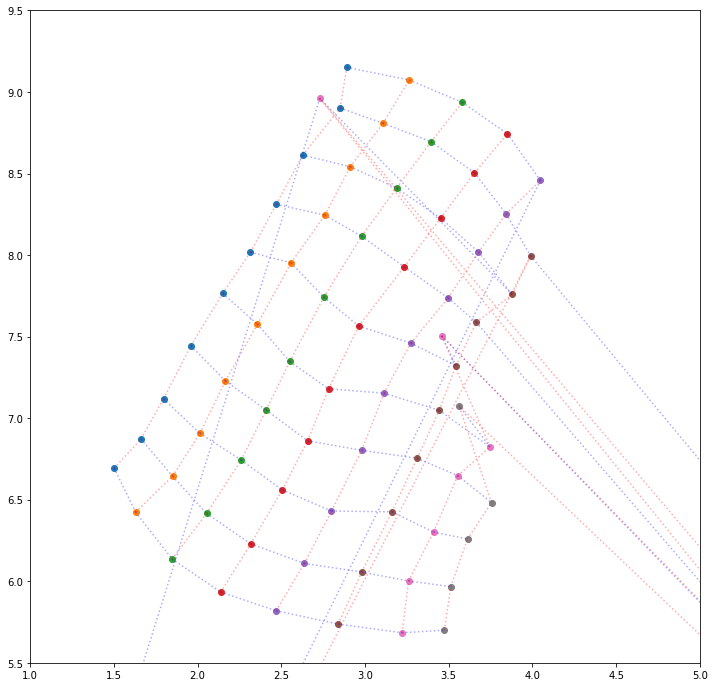

In [13]:
## visualize control points in X-space
fig, ax = plt.subplots(figsize=(12,12))

ax.set_xlim([1.0,5.0])
ax.set_ylim([5.5,9.5])

#ax.triplot(x[:,0], x[:,1], tri, linewidth=1.0)

## grid points
ax.plot(P_ix, P_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        plt.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        plt.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

plt.show()

In [14]:
## [TODO] filter out 

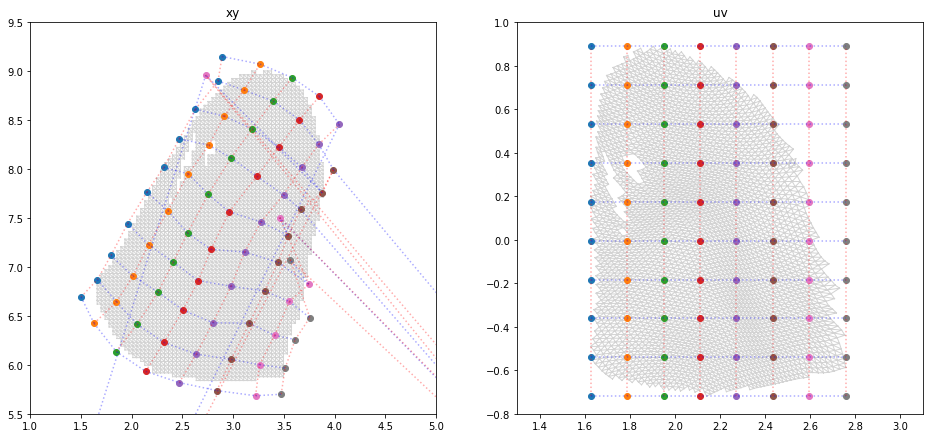

In [15]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7.2))

########################################
## XY space
########################################
ax1.set_xlim([1.0,5.0])
ax1.set_ylim([5.5,9.5])
#ax1.invert_yaxis()

ax1.triplot(x[:,0], x[:,1], tri, linewidth=1, color='lightgray')

## grid points
ax1.plot(P_ix, P_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax1.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax1.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

########################################
## UV space
########################################
ax2.set_xlim([1.3,3.1])
ax2.set_ylim([-0.8,1.0])

ax2.triplot(u[:,0], u[:,1], tri, linewidth=1, color='lightgray')

## grid points
ax2.plot(B_ix, B_jy, 'o')

## draw lines between grid points
for Bx in B_i:
    ax2.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    ax2.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

ax1.set_title('xy')
ax2.set_title('uv')

plt.show()

In [16]:
## [TEMPORARY] filtering out some parts
B_filter = np.full(B_ix.shape, False, dtype=bool)

B_filter[4,7] = True ## ?

B_filter[5,6] = True ## ?
B_filter[5,7] = True

B_filter[6,6] = True ## ?
B_filter[6,7] = True

B_filter[7,6] = True ## ?
B_filter[7,7] = True

B_filter[8,6] = True
B_filter[8,7] = True

B_filter[9,5] = True
B_filter[9,6] = True
B_filter[9,7] = True

B_filter = ~B_filter

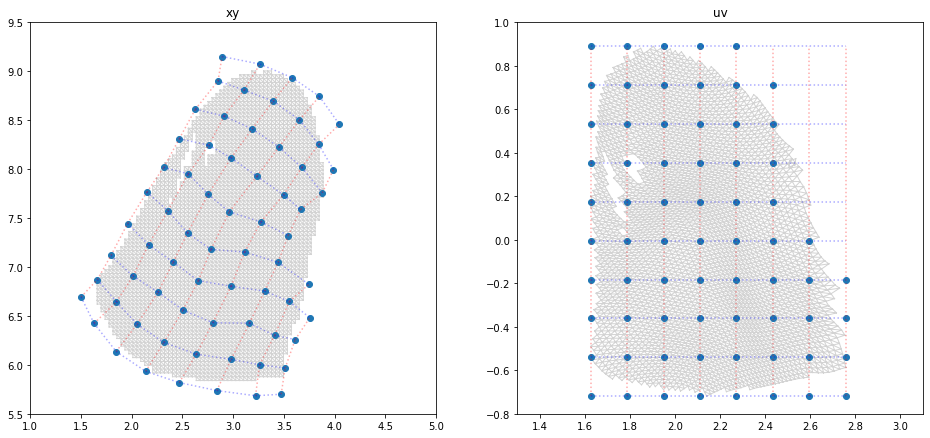

In [17]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7.2))

########################################
## XY space
########################################
ax1.set_xlim([1.0,5.0])
ax1.set_ylim([5.5,9.5])
#ax1.invert_yaxis()

ax1.triplot(x[:,0], x[:,1], tri, linewidth=1, color='lightgray')

## grid points
ax1.plot(P_ix[B_filter], P_jy[B_filter], 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        if B_filter[j,1] and B_filter[j,i+1]:
            ax1.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        if B_filter[j,1] and B_filter[j+1,i]:
            ax1.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

########################################
## UV space
########################################
ax2.set_xlim([1.3,3.1])
ax2.set_ylim([-0.8,1.0])

ax2.triplot(u[:,0], u[:,1], tri, linewidth=1, color='lightgray')

## grid points
ax2.plot(B_ix[B_filter], B_jy[B_filter], 'o')

## draw lines between grid points
for Bx in B_i:
    ax2.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    ax2.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

ax1.set_title('xy')
ax2.set_title('uv')

plt.show()

(end)